#주식 예측 알고리즘

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import locale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class StockPredictor:
    def __init__(self, stock_symbol):
        # 클래스 초기화 메서드, 주식 심볼을 받아와서 인스턴스 변수로 저장
        self.stock_symbol = stock_symbol
        self.df = self.download_data()  # 주식 데이터를 다운로드하는 메서드 호출
        self.short_window = 50
        self.long_window = 200
        self.W = tf.Variable(1.0)  # TensorFlow 변수로 선언한 선형 회귀 모델의 가중치
        self.b = tf.Variable(0.5)  # TensorFlow 변수로 선언한 선형 회귀 모델의 편향
        self.W_grad = None  # 가중치의 그래디언트를 저장하는 변수
        self.b_grad = None  # 편향의 그래디언트를 저장하는 변수
        self.learning_rate = 0.000000999  # 학습률

    def download_data(self):
        # Yahoo Finance에서 주식 데이터를 다운로드하는 메서드
        df = yf.download(self.stock_symbol, start="2020-01-01", end=pd.to_datetime('today'))
        return df

    def calculate_moving_averages(self):
        # 이동평균을 계산하는 메서드
        self.df['Short_MA'] = self.df['Close'].rolling(window=self.short_window, min_periods=1).mean()
        self.df['Long_MA'] = self.df['Close'].rolling(window=self.long_window, min_periods=1).mean()

    def generate_signals(self):
        # 골든크로스와 데드크로스 신호를 생성하는 메서드
        self.df['Golden_Cross_Signal'] = (self.df['Short_MA'] > self.df['Long_MA']) & (self.df['Short_MA'].shift(1) <= self.df['Long_MA'].shift(1))
        self.df['Dead_Cross_Signal'] = (self.df['Short_MA'] < self.df['Long_MA']) & (self.df['Short_MA'].shift(1) >= self.df['Long_MA'].shift(1))

    def plot_moving_averages(self):
        # 이동평균과 신호를 포함한 주식 가격 그래프를 그리는 메서드
        plt.figure(figsize=(10, 6))
        plt.plot(self.df.index, self.df['Close'], label='Close Price')
        plt.plot(self.df.index, self.df['Short_MA'], label=f'{self.short_window} days MA', linestyle='--')
        plt.plot(self.df.index, self.df['Long_MA'], label=f'{self.long_window} days MA', linestyle='--')

        plt.scatter(self.df.index[self.df['Golden_Cross_Signal']], self.df['Close'][self.df['Golden_Cross_Signal']], marker='o', color='red', label='Golden Cross')
        plt.scatter(self.df.index[self.df['Dead_Cross_Signal']], self.df['Close'][self.df['Dead_Cross_Signal']], marker='o', color='blue', label='Dead Cross')

        plt.title(f'{self.stock_symbol} Stock Price with Moving Averages and Cross Signals')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def preprocess_data(self):
        # 주식 데이터를 전처리하는 메서드, 일일 수익률을 계산하고 결측치를 제거
        self.df['Daily_Return'] = self.df['Close'].pct_change()
        self.df = self.df.dropna()

    def prepare_training_data(self):
        # 학습 데이터를 준비하는 메서드, 입력 데이터와 출력 데이터 반환
        x_data = np.arange(len(self.df['Close']))
        y_data = self.df['Close'].values
        return x_data, y_data

    def train_linear_regression(self, x_data, y_data):
        # 선형 회귀 모델을 학습하는 메서드
        for i in range(20001):
            with tf.GradientTape() as tape:
                hypothesis = self.W * x_data + self.b
                cost = tf.reduce_mean(tf.square(hypothesis - y_data))
            self.W_grad, self.b_grad = tape.gradient(cost, [self.W, self.b])
            self.W.assign_sub(self.learning_rate * self.W_grad)
            self.b.assign_sub(self.learning_rate * self.b_grad)

            if i > 500 and i % 1000 == 0:
                print("{:5}|{:10.4f}|{:10.4f}| cost = {:10.6f}".format(i, self.W.numpy(), self.b.numpy(), cost))

    def predict_stock_price(self, x_pred):
        # 학습된 모델을 사용하여 주식 가격을 예측하는 메서드
        hypothesis = self.W * x_pred + self.b
        predicted_price = hypothesis.numpy()[0]
        return predicted_price

    def plot_cost_over_iterations(self, x_axis_loop, y_axis_cost):
        # 학습 과정에서의 비용을 그래프로 그리는 메서드
        plt.plot(x_axis_loop, y_axis_cost, label='Cost')
        plt.title('Cost over iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.legend()
        plt.show()

    def plot_price_prediction(self, y_test, predictions):
        # 주식 가격 예측 결과를 그래프로 그리는 메서드
        plt.figure(figsize=(10, 6))
        plt.plot(self.df.index[-len(y_test):], y_test, label='True Values')
        plt.plot(self.df.index[-len(y_test):], predictions, label='Predictions', linestyle='--')
        plt.title(f'{self.stock_symbol} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def trading_strategy(self):
        capital_won = 10000000  # 초기 자본 (원화)
        capital_usd = 10000  # 초기 자본 (달러)
        position = 0  # 보유 중인 주식 수
        usd_per_trade = 1000  # 각 거래에 사용할 달러 금액

        for i in range(1, len(self.df)):
            # 골든크로스 시 매수
            if self.df['Golden_Cross_Signal'][i] and position == 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매수
                    position += capital_won // self.df['Close'][i]
                    capital_won -= position * self.df['Close'][i]
                else:
                    # 달러로 매수
                    position += capital_usd // self.df['Close'][i]
                    capital_usd -= position * self.df['Close'][i]

            # 단기이평선이 한 번 꺾일 때 절반 매도
            if self.df['Short_MA'][i] < self.df['Short_MA'][i-1] and position > 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매도
                    capital_won += position * self.df['Close'][i] // 2
                else:
                    # 달러로 매도
                    capital_usd += position * self.df['Close'][i] // 2
                position //= 2

            # 데드크로스 시 나머지 매도
            if self.df['Dead_Cross_Signal'][i] and position > 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매도
                    capital_won += position * self.df['Close'][i]
                else:
                    # 달러로 매도
                    capital_usd += position * self.df['Close'][i]
                position = 0

        # 최종 자산 계산
        final_assets_won = capital_won + position * self.df['Close'].iloc[-1]
        final_assets_usd = capital_usd + position * self.df['Close'].iloc[-1]

        return final_assets_won, final_assets_usd

if __name__ == "__main__":
    stock_symbol = input("yfinance에서 가져올 주식 코드를 입력하세요: ") # 009150.KS(삼성전기),005930.KS(삼성전자),035420.KS(네이버), AMD, TSMC34.SA, 041510.KS(SM), TSLA(테슬라), AAPL(애플), NVDA(엔비디아), BTC-USD(비트코인), ETH-USD(이더리움) , GC=F(금)
    predictor = StockPredictor(stock_symbol) # 041510.KS(SM)
    predictor.calculate_moving_averages()
    predictor.generate_signals()
    predictor.plot_moving_averages()
    predictor.preprocess_data()
    x_data, y_data = predictor.prepare_training_data()
    predictor.train_linear_regression(x_data, y_data)

    # 2023년 12월 1일의 예측값 표시
    x_axis_loop = []
    y_axis_cost = []

    x_pred = [len(predictor.df['Close'])]  # 마지막 데이터 인덱스로 예측
    predicted_price = predictor.predict_stock_price(x_pred)
    print(f"2023년 12월 1일의 예측값: {predicted_price}")

    #predictor.plot_cost_over_iterations(x_axis_loop, y_axis_cost)

    features = predictor.df[['Open', 'High', 'Low', 'Close']]
    target = predictor.df['Close'].shift(-1)
    df_cleaned = pd.concat([features, target], axis=1).dropna()

    X_train, X_test, y_train, y_test = train_test_split(df_cleaned.iloc[:, :-1], df_cleaned.iloc[:, -1], test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    predictor.plot_price_prediction(y_test, predictions)

    # 로케일을 한국으로 설정
    try:
        locale.setlocale(locale.LC_ALL, 'ko_KR.UTF8')
    except locale.Error:
        # 지원되지 않는 로케일이면 기본 로케일로 변경
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

    final_assets_won, final_assets_usd = predictor.trading_strategy()

    # 최종 자산 표시
    if 'KS' in predictor.stock_symbol:
        # 주식 심볼에 'KS'가 포함되어 있으면 원화로 간주
        print(f"최종 자산 (원화): {locale.currency(final_assets_won, grouping=True, symbol='₩')}")
        print(f"최종 자산 (달러): {final_assets_usd:.2f} $")
    else:
        # 그 외의 경우는 달러로 간주
        print(f"최종 자산 (원화): {final_assets_won:.2f} ₩")
        print(f"최종 자산 (달러): {locale.currency(final_assets_usd, grouping=True)}")

    # 원금 대비 수익률 계산
    initial_capital_won = 10000000  # 초기 자본 (원화)
    initial_capital_usd = 10000  # 초기 자본 (달러)

    returns_won = (final_assets_won - initial_capital_won) / initial_capital_won * 100
    returns_usd = (final_assets_usd - initial_capital_usd) / initial_capital_usd * 100

    # 수익률 표시
    if 'KS' in predictor.stock_symbol:
        # 주식 심볼에 'KS'가 포함되어 있으면 원화 수익률로 간주
        print(f"원금 대비 수익률 (원화): {returns_won:.2f}%")
        print(f"원금 대비 수익률 (달러): {returns_usd:.2f}%")
    else:
        # 그 외의 경우는 달러 수익률로 간주
        print(f"원금 대비 수익률 (원화): {returns_won:.2f}%")
        print(f"원금 대비 수익률 (달러): {returns_usd:.2f}%")

수정 1

yfinance에서 가져올 주식 코드를 입력하세요: TSLA
[*********************100%%**********************]  1 of 1 completed


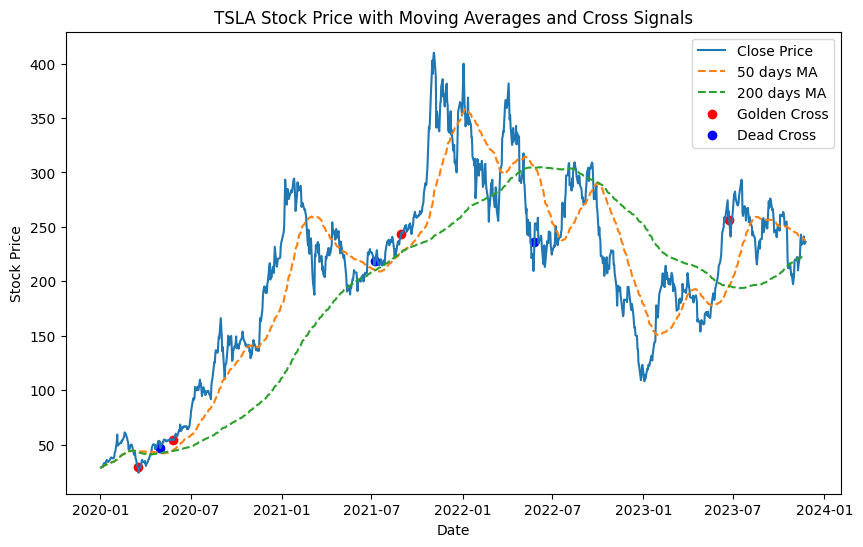

2023년 12월 1일의 예측값: 235.9005562908314


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf

class StockPredictor:
    def __init__(self, stock_symbol):
        self.stock_symbol = stock_symbol
        self.df = self.download_data()
        self.short_window = 50
        self.long_window = 200

    def download_data(self):
        df = yf.download(self.stock_symbol, start="2020-01-01", end=pd.to_datetime('today'))
        return df

    def calculate_moving_averages(self):
        self.df['Short_MA'] = self.df['Close'].rolling(window=self.short_window, min_periods=1).mean()
        self.df['Long_MA'] = self.df['Close'].rolling(window=self.long_window, min_periods=1).mean()

    def generate_signals(self):
        self.df['Golden_Cross_Signal'] = (self.df['Short_MA'] > self.df['Long_MA']) & (self.df['Short_MA'].shift(1) <= self.df['Long_MA'].shift(1))
        self.df['Dead_Cross_Signal'] = (self.df['Short_MA'] < self.df['Long_MA']) & (self.df['Short_MA'].shift(1) >= self.df['Long_MA'].shift(1))

    def plot_moving_averages(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.df.index, self.df['Close'], label='Close Price')
        plt.plot(self.df.index, self.df['Short_MA'], label=f'{self.short_window} days MA', linestyle='--')
        plt.plot(self.df.index, self.df['Long_MA'], label=f'{self.long_window} days MA', linestyle='--')

        plt.scatter(self.df.index[self.df['Golden_Cross_Signal']], self.df['Close'][self.df['Golden_Cross_Signal']], marker='o', color='red', label='Golden Cross')
        plt.scatter(self.df.index[self.df['Dead_Cross_Signal']], self.df['Close'][self.df['Dead_Cross_Signal']], marker='o', color='blue', label='Dead Cross')

        plt.title(f'{self.stock_symbol} Stock Price with Moving Averages and Cross Signals')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def prepare_training_data(self):
        window_size = 5

        x_data = []
        y_data = []

        for i in range(window_size, len(self.df)):
            x_data.append(self.df[['Open', 'High', 'Low', 'Close']].iloc[i-window_size:i].values.flatten())
            y_data.append(self.df['Close'].iloc[i])

        x_data = np.array(x_data)
        y_data = np.array(y_data)

        return x_data, y_data

    def train_linear_regression(self, x_data, y_data):
        model = LinearRegression()
        model.fit(x_data, y_data)
        return model

    def predict_stock_price(self, model):
        window_size = 5
        x_pred = [self.df[['Open', 'High', 'Low', 'Close']].iloc[-window_size:].values.flatten()]
        predicted_price = model.predict(x_pred)
        return predicted_price

if __name__ == "__main__":
    stock_symbol = input("yfinance에서 가져올 주식 코드를 입력하세요: ")
    predictor = StockPredictor(stock_symbol)
    predictor.calculate_moving_averages()
    predictor.generate_signals()
    predictor.plot_moving_averages()
    x_data, y_data = predictor.prepare_training_data()
    model = predictor.train_linear_regression(x_data, y_data)

    predicted_price = predictor.predict_stock_price(model)
    print(f"2023년 12월 1일의 예측값: {predicted_price[0]}")


주식 코드를 입력하세요 (예: AAPL): NVDA
[*********************100%%**********************]  1 of 1 completed
Iteration 0/20000 - Cost: 3.1446247519894626
Iteration 1000/20000 - Cost: 3.1446247519894626
Iteration 2000/20000 - Cost: 3.1446247519894626
Iteration 3000/20000 - Cost: 3.1446247519894626
Iteration 4000/20000 - Cost: 3.1446247519894626
Iteration 5000/20000 - Cost: 3.1446247519894626
Iteration 6000/20000 - Cost: 3.1446247519894626
Iteration 7000/20000 - Cost: 3.1446247519894626
Iteration 8000/20000 - Cost: 3.1446247519894626
Iteration 9000/20000 - Cost: 3.1446247519894626
Iteration 10000/20000 - Cost: 3.1446247519894626
Iteration 11000/20000 - Cost: 3.1446247519894626
Iteration 12000/20000 - Cost: 3.1446247519894626
Iteration 13000/20000 - Cost: 3.1446247519894626
Iteration 14000/20000 - Cost: 3.1446247519894626
Iteration 15000/20000 - Cost: 3.1446247519894626
Iteration 16000/20000 - Cost: 3.1446247519894626
Iteration 17000/20000 - Cost: 3.1446247519894626
Iteration 18000/20000 - Cost: 3.1

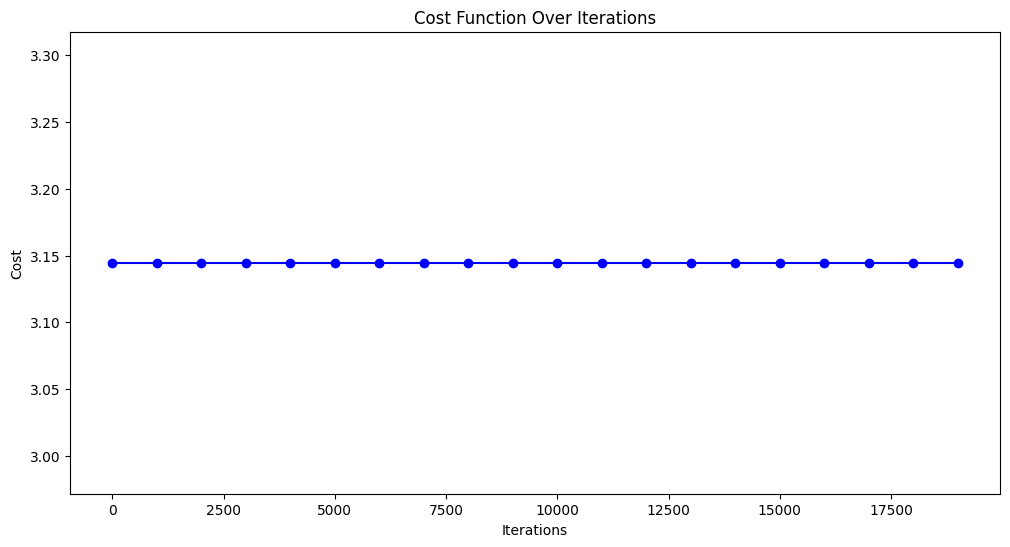

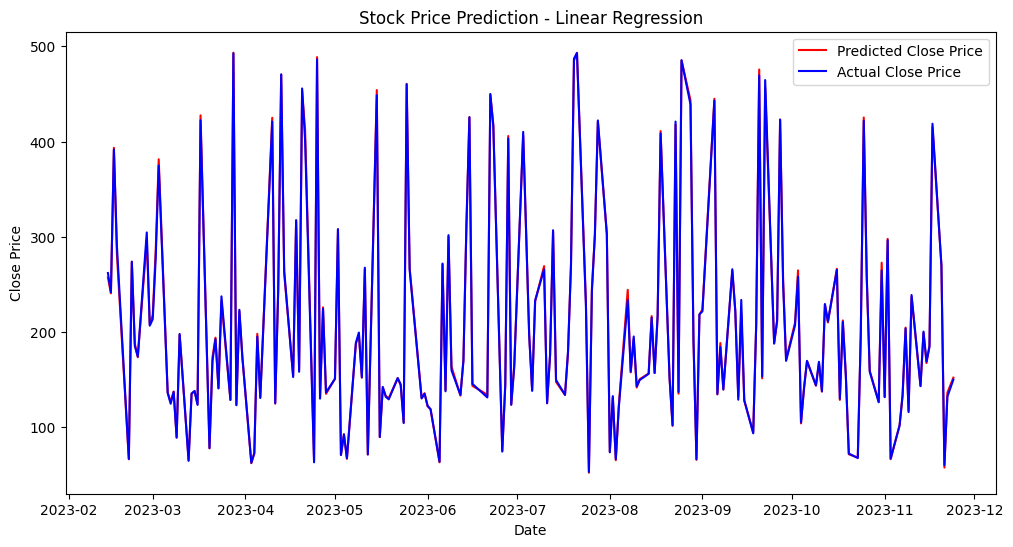

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 주식 코드 입력 받기
stock_code = input("주식 코드를 입력하세요 (예: AAPL): ")

# Yahoo Finance에서 주식 데이터 가져오기
stock_data = yf.download(stock_code, start="2020-01-01", end="2023-11-25")
#df = yf.download(self.stock_symbol, start="2020-01-01", end=pd.to_datetime('today'))
        #return df

# 골든 크로스 및 데드크로스 계산
stock_data['Short_MA'] = stock_data['Close'].rolling(window=20, min_periods=1).mean()
stock_data['Long_MA'] = stock_data['Close'].rolling(window=200, min_periods=1).mean()
stock_data['Signal'] = 0.0

# 골든 크로스 (단기 이평선이 장기 이평선을 상향 돌파)
stock_data.loc[stock_data['Short_MA'] > stock_data['Long_MA'], 'Signal'] = 1.0

# 데드크로스 (단기 이평선이 장기 이평선을 하향 돌파)
stock_data.loc[stock_data['Short_MA'] < stock_data['Long_MA'], 'Signal'] = -1.0

# 다중 선형 회귀에 사용할 특징 선택
features = ['Open', 'High', 'Low']

# 독립 변수(X) 및 종속 변수(y) 설정
X = stock_data[features]
y = stock_data['Close']

# 학습 및 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 다중 선형 회귀 모델 학습
model = LinearRegression()

# 비용 기록을 위한 리스트
cost_history = []

# 학습
num_iterations = 20000
learning_rate = 0.0000001

for i in range(num_iterations):
    # 모델 학습
    model.fit(X_train, y_train)

    # 비용 계산 및 기록
    cost = np.mean((model.predict(X_train) - y_train) ** 2) / 2.0
    cost_history.append(cost)

    # 비용 출력 (일정 간격으로 출력)
    if i % 1000 == 0:
        print(f"Iteration {i}/{num_iterations} - Cost: {cost}")

# 예측값 생성
predictions = model.predict(X_test)

# 비용 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_iterations, 1000), cost_history[::1000], marker='o', linestyle='-', color='b')
plt.title('Cost Function Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted Close Price', color='red')
plt.plot(stock_data.index[-len(predictions):], y_test.values, label='Actual Close Price', color='blue')
plt.title('Stock Price Prediction - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


다중선형회귀 추가

[*********************100%%**********************]  1 of 1 completed


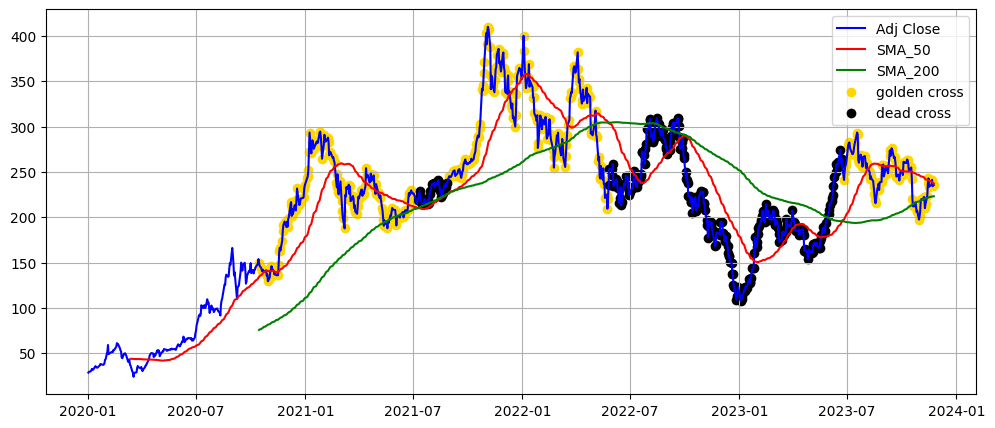

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 주식 데이터 받아오기
stock_code = "TSLA"
start_date = "2020-01-01"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
data = yf.download(stock_code, start=start_date, end=end_date)

# open, close, high, low 데이터로 다중선형회귀 모델 학습
X = data[['Open', 'Close', 'High', 'Low']]
y = data['Adj Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# 골든크로스와 데드크로스 지점 찾기
data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()
data['SMA_200'] = data['Adj Close'].rolling(window=200).mean()
golden_cross = data[data['SMA_50'] > data['SMA_200']]
dead_cross = data[data['SMA_50'] < data['SMA_200']]

# 그래프 그리기
plt.figure(figsize=(12, 5))
plt.plot(data['Adj Close'], label='Adj Close', color='blue')
plt.plot(data['SMA_50'], label='SMA_50', color='red')
plt.plot(data['SMA_200'], label='SMA_200', color='green')
plt.scatter(golden_cross.index, golden_cross['Adj Close'], color='gold', label='golden cross')
plt.scatter(dead_cross.index, dead_cross['Adj Close'], color='black', label='dead cross')
plt.legend()
plt.grid()
plt.show()

MFI추가

[*********************100%%**********************]  1 of 1 completed


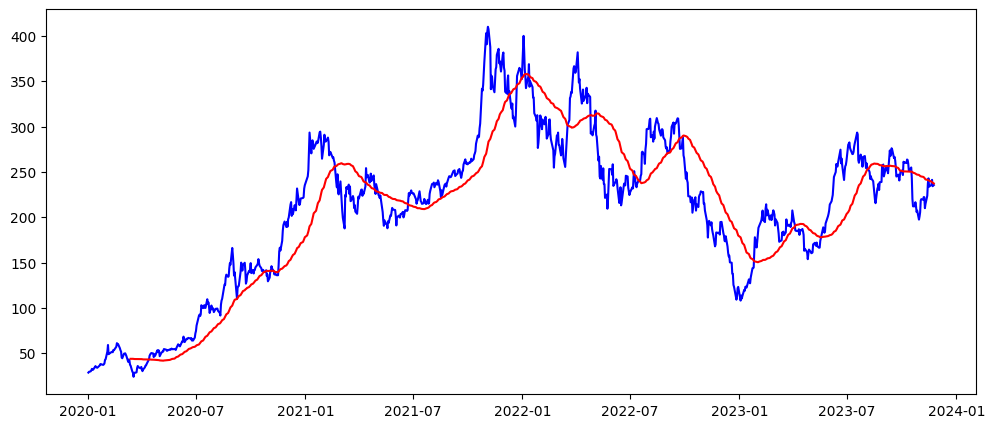

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 주식 데이터 받아오기
stock_code = "TSLA"
start_date = "2020-01-01"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
data = yf.download(stock_code, start=start_date, end=end_date)

# open, close, high, low 데이터로 다중선형회귀 모델 학습
X = data[['Open', 'Close', 'High', 'Low']]
y = data['Adj Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# 골든크로스와 데드크로스 지점 찾기
data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()
data['SMA_200'] = data['Adj Close'].rolling(window=200).mean()
golden_cross = data[data['SMA_50'] > data['SMA_200']]
dead_cross = data[data['SMA_50'] < data['SMA_200']]

# MFI 계산
typical_price = (data['High'] + data['Low'] + data['Close']) / 3
money_flow = typical_price * data['Volume']
data['Positive_Money_Flow'] = np.where(typical_price > typical_price.shift(1), money_flow, 0)
data['Negative_Money_Flow'] = np.where(typical_price < typical_price.shift(1), money_flow, 0)
positive_money_flow = data['Positive_Money_Flow'].rolling(window=14).sum()
negative_money_flow = data['Negative_Money_Flow'].rolling(window=14).sum()
money_flow_ratio = positive_money_flow / negative_money_flow
data['MFI'] = 100 - (100 / (1 + money_flow_ratio))

# 그래프 그리기
plt.figure(figsize=(12, 5))
plt.plot(data['Adj Close'], label='Adj Close', color='blue')
plt.plot(data['SMA_50'], label='SMA_50', color='red')


모르겠다 이젠..


yfinance에서 가져올 주식 코드를 입력하세요: TSLA
[*********************100%%**********************]  1 of 1 completed


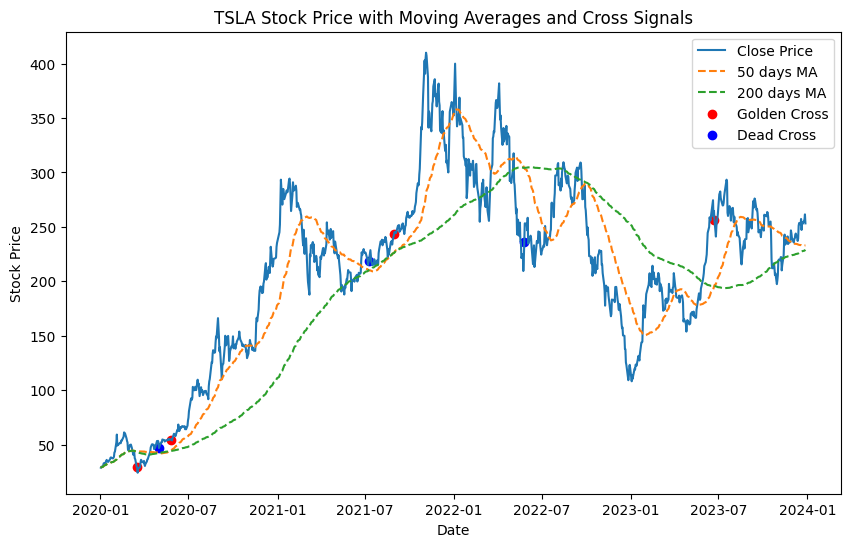

최종 자산 (원화): 10000000.00 ₩
최종 자산 (달러): $26,274.89
원금 대비 수익률 (원화): 0.00%
원금 대비 수익률 (달러): 162.75%


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import locale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class StockPredictor:
    def __init__(self, stock_symbol):
        # 클래스 초기화 메서드, 주식 심볼을 받아와서 인스턴스 변수로 저장
        self.stock_symbol = stock_symbol
        self.df = self.download_data()  # 주식 데이터를 다운로드하는 메서드 호출
        self.short_window = 50
        self.long_window = 200
        self.W = tf.Variable(1.0)  # TensorFlow 변수로 선언한 선형 회귀 모델의 가중치
        self.b = tf.Variable(0.5)  # TensorFlow 변수로 선언한 선형 회귀 모델의 편향
        self.W_grad = None  # 가중치의 그래디언트를 저장하는 변수
        self.b_grad = None  # 편향의 그래디언트를 저장하는 변수
        self.learning_rate = 0.000000999  # 학습률

    def download_data(self):
        # Yahoo Finance에서 주식 데이터를 다운로드하는 메서드
        df = yf.download(self.stock_symbol, start="2020-01-01", end=pd.to_datetime('today'))
        return df

    def calculate_moving_averages(self):
        # 이동평균을 계산하는 메서드
        self.df['Short_MA'] = self.df['Close'].rolling(window=self.short_window, min_periods=1).mean()
        self.df['Long_MA'] = self.df['Close'].rolling(window=self.long_window, min_periods=1).mean()

    def generate_signals(self):
        # 골든크로스와 데드크로스 신호를 생성하는 메서드
        self.df['Golden_Cross_Signal'] = (self.df['Short_MA'] > self.df['Long_MA']) & (self.df['Short_MA'].shift(1) <= self.df['Long_MA'].shift(1))
        self.df['Dead_Cross_Signal'] = (self.df['Short_MA'] < self.df['Long_MA']) & (self.df['Short_MA'].shift(1) >= self.df['Long_MA'].shift(1))

    def plot_moving_averages(self):
        # 이동평균과 신호를 포함한 주식 가격 그래프를 그리는 메서드
        plt.figure(figsize=(10, 6))
        plt.plot(self.df.index, self.df['Close'], label='Close Price')
        plt.plot(self.df.index, self.df['Short_MA'], label=f'{self.short_window} days MA', linestyle='--')
        plt.plot(self.df.index, self.df['Long_MA'], label=f'{self.long_window} days MA', linestyle='--')

        plt.scatter(self.df.index[self.df['Golden_Cross_Signal']], self.df['Close'][self.df['Golden_Cross_Signal']], marker='o', color='red', label='Golden Cross')
        plt.scatter(self.df.index[self.df['Dead_Cross_Signal']], self.df['Close'][self.df['Dead_Cross_Signal']], marker='o', color='blue', label='Dead Cross')

        plt.title(f'{self.stock_symbol} Stock Price with Moving Averages and Cross Signals')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def preprocess_data(self):
        # 주식 데이터를 전처리하는 메서드, 일일 수익률을 계산하고 결측치를 제거
        self.df['Daily_Return'] = self.df['Close'].pct_change()
        self.df = self.df.dropna()

    def prepare_training_data(self):
      # 학습 데이터를 준비하는 메서드, 입력 데이터와 출력 데이터 반환
      x_data = tf.dtypes.cast(self.df[['Open', 'High', 'Low', 'Close']].to_numpy(), tf.double)
      y_data = tf.dtypes.cast(self.df['Close'].values, tf.double)
      return x_data, y_data

    def train_linear_regression(self, x_data, y_data): # 선형 회귀 모델을 학습하는 메서드
      self.W = tf.Variable(tf.random.normal([4, 1]))
      self.b = tf.Variable(tf.random.normal([1]))
      for i in range(20001):
        with tf.GradientTape() as tape:
            hypothesis = tf.matmul(x_data, self.W) + self.b
            cost = tf.reduce_mean(tf.square(hypothesis - y_data))
        self.W_grad, self.b_grad = tape.gradient(cost, [self.W, self.b])
        self.W.assign_sub(self.learning_rate * self.W_grad)
        self.b.assign_sub(self.learning_rate * self.b_grad)

        if i > 500 and i % 1000 == 0:
            print("{:5}|{:10.4f}|{:10.4f}| cost = {:10.6f}".format(i, self.W.numpy(), self.b.numpy(), cost))


    def predict_stock_price(self, x_pred):
        # 학습된 모델을 사용하여 주식 가격을 예측하는 메서드
        hypothesis = self.W * x_pred + self.b
        predicted_price = hypothesis.numpy()[0]
        return predicted_price

    def plot_cost_over_iterations(self, x_axis_loop, y_axis_cost):
        # 학습 과정에서의 비용을 그래프로 그리는 메서드
        plt.plot(x_axis_loop, y_axis_cost, label='Cost')
        plt.title('Cost over iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.legend()
        plt.show()

    def plot_price_prediction(self, y_test, predictions):
        # 주식 가격 예측 결과를 그래프로 그리는 메서드
        plt.figure(figsize=(10, 6))
        plt.plot(self.df.index[-len(y_test):], y_test, label='True Values')
        plt.plot(self.df.index[-len(y_test):], predictions, label='Predictions', linestyle='--')
        plt.title(f'{self.stock_symbol} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def trading_strategy(self):
        capital_won = 10000000  # 초기 자본 (원화)
        capital_usd = 10000  # 초기 자본 (달러)
        position = 0  # 보유 중인 주식 수
        usd_per_trade = 1000  # 각 거래에 사용할 달러 금액

        for i in range(1, len(self.df)):
            # 골든크로스 시 매수
            if self.df['Golden_Cross_Signal'][i] and position == 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매수
                    position += capital_won // self.df['Close'][i]
                    capital_won -= position * self.df['Close'][i]
                else:
                    # 달러로 매수
                    position += capital_usd // self.df['Close'][i]
                    capital_usd -= position * self.df['Close'][i]

            # 단기이평선이 한 번 꺾일 때 절반 매도
            if self.df['Short_MA'][i] < self.df['Short_MA'][i-1] and position > 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매도
                    capital_won += position * self.df['Close'][i] // 2
                else:
                    # 달러로 매도
                    capital_usd += position * self.df['Close'][i] // 2
                position //= 2

            # 데드크로스 시 나머지 매도
            if self.df['Dead_Cross_Signal'][i] and position > 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매도
                    capital_won += position * self.df['Close'][i]
                else:
                    # 달러로 매도
                    capital_usd += position * self.df['Close'][i]
                position = 0

        # 최종 자산 계산
        final_assets_won = capital_won + position * self.df['Close'].iloc[-1]
        final_assets_usd = capital_usd + position * self.df['Close'].iloc[-1]

        return final_assets_won, final_assets_usd

if __name__ == "__main__":
    stock_symbol = input("yfinance에서 가져올 주식 코드를 입력하세요: ") # 009150.KS(삼성전기),005930.KS(삼성전자),035420.KS(네이버), AMD, TSMC34.SA, 041510.KS(SM), TSLA(테슬라), AAPL(애플), NVDA(엔비디아), BTC-USD(비트코인), ETH-USD(이더리움) , GC=F(금)
    predictor = StockPredictor(stock_symbol) # 041510.KS(SM)
    predictor.calculate_moving_averages()
    predictor.generate_signals()
    predictor.plot_moving_averages()
    predictor.preprocess_data()
    x_data, y_data = predictor.prepare_training_data()
    #predictor.train_linear_regression(x_data, y_data)

    # 로케일을 한국으로 설정
    try:
        locale.setlocale(locale.LC_ALL, 'ko_KR.UTF8')
    except locale.Error:
        # 지원되지 않는 로케일이면 기본 로케일로 변경
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

    final_assets_won, final_assets_usd = predictor.trading_strategy()

    # 최종 자산 표시
    if 'KS' in predictor.stock_symbol:
        # 주식 심볼에 'KS'가 포함되어 있으면 원화로 간주
        print(f"최종 자산 (원화): {locale.currency(final_assets_won, grouping=True, symbol='₩')}")
        print(f"최종 자산 (달러): {final_assets_usd:.2f} $")
    else:
        # 그 외의 경우는 달러로 간주
        print(f"최종 자산 (원화): {final_assets_won:.2f} ₩")
        print(f"최종 자산 (달러): {locale.currency(final_assets_usd, grouping=True)}")

    # 원금 대비 수익률 계산
    initial_capital_won = 10000000  # 초기 자본 (원화)
    initial_capital_usd = 10000  # 초기 자본 (달러)

    returns_won = (final_assets_won - initial_capital_won) / initial_capital_won * 100
    returns_usd = (final_assets_usd - initial_capital_usd) / initial_capital_usd * 100

    # 수익률 표시
    if 'KS' in predictor.stock_symbol:
        # 주식 심볼에 'KS'가 포함되어 있으면 원화 수익률로 간주
        print(f"원금 대비 수익률 (원화): {returns_won:.2f}%")
        print(f"원금 대비 수익률 (달러): {returns_usd:.2f}%")
    else:
        # 그 외의 경우는 달러 수익률로 간주
        print(f"원금 대비 수익률 (원화): {returns_won:.2f}%")
        print(f"원금 대비 수익률 (달러): {returns_usd:.2f}%")

yfinance에서 가져올 주식 코드를 입력하세요: TSLA
[*********************100%%**********************]  1 of 1 completed


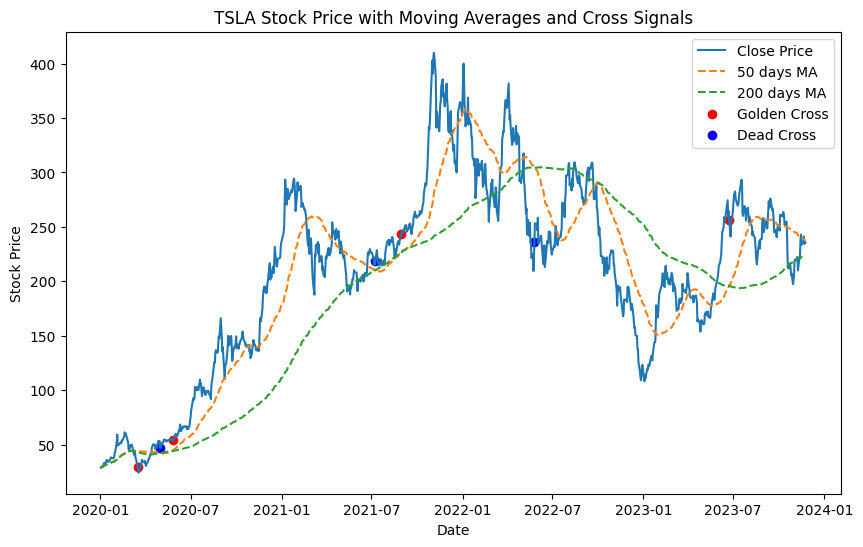

최종 자산 (원화): 10000000.00 ₩
최종 자산 (달러): $26,274.89
원금 대비 수익률 (원화): 0.00%
원금 대비 수익률 (달러): 162.75%


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import locale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class StockPredictor:
    def __init__(self, stock_symbol):
        # 클래스 초기화 메서드, 주식 심볼을 받아와서 인스턴스 변수로 저장
        self.stock_symbol = stock_symbol
        self.df = self.download_data()  # 주식 데이터를 다운로드하는 메서드 호출
        self.short_window = 50
        self.long_window = 200
        self.W = tf.Variable(1.0)  # TensorFlow 변수로 선언한 선형 회귀 모델의 가중치
        self.b = tf.Variable(0.5)  # TensorFlow 변수로 선언한 선형 회귀 모델의 편향
        self.W_grad = None  # 가중치의 그래디언트를 저장하는 변수
        self.b_grad = None  # 편향의 그래디언트를 저장하는 변수
        self.learning_rate = 0.000000999  # 학습률

    def download_data(self):
        # Yahoo Finance에서 주식 데이터를 다운로드하는 메서드
        df = yf.download(self.stock_symbol, start="2020-01-01", end=pd.to_datetime('today'))
        return df

    def calculate_moving_averages(self):
        # 이동평균을 계산하는 메서드
        self.df['Short_MA'] = self.df['Close'].rolling(window=self.short_window, min_periods=1).mean()
        self.df['Long_MA'] = self.df['Close'].rolling(window=self.long_window, min_periods=1).mean()

    def generate_signals(self):
        # 골든크로스와 데드크로스 신호를 생성하는 메서드
        self.df['Golden_Cross_Signal'] = (self.df['Short_MA'] > self.df['Long_MA']) & (self.df['Short_MA'].shift(1) <= self.df['Long_MA'].shift(1))
        self.df['Dead_Cross_Signal'] = (self.df['Short_MA'] < self.df['Long_MA']) & (self.df['Short_MA'].shift(1) >= self.df['Long_MA'].shift(1))

    def plot_moving_averages(self):
        # 이동평균과 신호를 포함한 주식 가격 그래프를 그리는 메서드
        plt.figure(figsize=(10, 6))
        plt.plot(self.df.index, self.df['Close'], label='Close Price')
        plt.plot(self.df.index, self.df['Short_MA'], label=f'{self.short_window} days MA', linestyle='--')
        plt.plot(self.df.index, self.df['Long_MA'], label=f'{self.long_window} days MA', linestyle='--')

        plt.scatter(self.df.index[self.df['Golden_Cross_Signal']], self.df['Close'][self.df['Golden_Cross_Signal']], marker='o', color='red', label='Golden Cross')
        plt.scatter(self.df.index[self.df['Dead_Cross_Signal']], self.df['Close'][self.df['Dead_Cross_Signal']], marker='o', color='blue', label='Dead Cross')

        plt.title(f'{self.stock_symbol} Stock Price with Moving Averages and Cross Signals')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def preprocess_data(self):
        # 주식 데이터를 전처리하는 메서드, 일일 수익률을 계산하고 결측치를 제거
        self.df['Daily_Return'] = self.df['Close'].pct_change()
        self.df = self.df.dropna()

    def prepare_training_data(self):
      # 학습 데이터를 준비하는 메서드, 입력 데이터와 출력 데이터 반환
      x_data = tf.dtypes.cast(self.df[['Open', 'High', 'Low', 'Close']].to_numpy(), tf.double)
      y_data = tf.dtypes.cast(self.df['Close'].values, tf.double)
      return x_data, y_data

    def train_linear_regression(self, x_data, y_data):
      # 초기화된 모델 가중치 및 편향
      self.W = tf.Variable(tf.random.normal([4, 1]))
      self.b = tf.Variable(tf.random.normal([1]))

      cost_history = []  # 비용 변화를 저장할 리스트

      for i in range(20001):
        with tf.GradientTape() as tape:
          hypothesis = tf.matmul(x_data, self.W) + self.b
          cost = tf.reduce_mean(tf.square(hypothesis - y_data))

          self.W_grad, self.b_grad = tape.gradient(cost, [self.W, self.b])
          self.W.assign_sub(self.learning_rate * self.W_grad)
          self.b.assign_sub(self.learning_rate * self.b_grad)

        if i > 500 and i % 1000 == 0:
            print("{:5}|{:10.4f}|{:10.4f}| cost = {:10.6f}".format(i, self.W.numpy()[0][0], self.b.numpy()[0], cost))

        if i % 1000 == 0:
            cost_history.append(cost.numpy())

      # 비용 변화 시각화
      if cost_history:
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, 20001, 1000), cost_history, marker='o', linestyle='-', color='b')
        plt.title('Cost Function Over Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.show()

    def predict_stock_price(self, x_pred):
        # 학습된 모델을 사용하여 주식 가격을 예측하는 메서드
        hypothesis = self.W * x_pred + self.b
        predicted_price = hypothesis.numpy()[0]
        return predicted_price

    def plot_cost_over_iterations(self, x_axis_loop, y_axis_cost):
        # 학습 과정에서의 비용을 그래프로 그리는 메서드
        plt.plot(x_axis_loop, y_axis_cost, label='Cost')
        plt.title('Cost over iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.legend()
        plt.show()

    def plot_price_prediction(self, y_test, predictions):
        # 주식 가격 예측 결과를 그래프로 그리는 메서드
        plt.figure(figsize=(10, 6))
        plt.plot(self.df.index[-len(y_test):], y_test, label='True Values')
        plt.plot(self.df.index[-len(y_test):], predictions, label='Predictions', linestyle='--')
        plt.title(f'{self.stock_symbol} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def trading_strategy(self):
        capital_won = 10000000  # 초기 자본 (원화)
        capital_usd = 10000  # 초기 자본 (달러)
        position = 0  # 보유 중인 주식 수
        usd_per_trade = 1000  # 각 거래에 사용할 달러 금액

        for i in range(1, len(self.df)):
            # 골든크로스 시 매수
            if self.df['Golden_Cross_Signal'][i] and position == 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매수
                    position += capital_won // self.df['Close'][i]
                    capital_won -= position * self.df['Close'][i]
                else:
                    # 달러로 매수
                    position += capital_usd // self.df['Close'][i]
                    capital_usd -= position * self.df['Close'][i]

            # 단기이평선이 한 번 꺾일 때 절반 매도
            if self.df['Short_MA'][i] < self.df['Short_MA'][i-1] and position > 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매도
                    capital_won += position * self.df['Close'][i] // 2
                else:
                    # 달러로 매도
                    capital_usd += position * self.df['Close'][i] // 2
                position //= 2

            # 데드크로스 시 나머지 매도
            if self.df['Dead_Cross_Signal'][i] and position > 0:
                if 'KS' in self.stock_symbol:
                    # 원화로 매도
                    capital_won += position * self.df['Close'][i]
                else:
                    # 달러로 매도
                    capital_usd += position * self.df['Close'][i]
                position = 0

        # 최종 자산 계산
        final_assets_won = capital_won + position * self.df['Close'].iloc[-1]
        final_assets_usd = capital_usd + position * self.df['Close'].iloc[-1]

        return final_assets_won, final_assets_usd

if __name__ == "__main__":
    stock_symbol = input("yfinance에서 가져올 주식 코드를 입력하세요: ") # 009150.KS(삼성전기),005930.KS(삼성전자),035420.KS(네이버), AMD, TSMC34.SA, 041510.KS(SM), TSLA(테슬라), AAPL(애플), NVDA(엔비디아), BTC-USD(비트코인), ETH-USD(이더리움) , GC=F(금)
    predictor = StockPredictor(stock_symbol) # 041510.KS(SM)
    predictor.calculate_moving_averages()
    predictor.generate_signals()
    predictor.plot_moving_averages()
    predictor.preprocess_data()
    x_data, y_data = predictor.prepare_training_data()
    #predictor.train_linear_regression(x_data, y_data)

    # 로케일을 한국으로 설정
    try:
        locale.setlocale(locale.LC_ALL, 'ko_KR.UTF8')
    except locale.Error:
        # 지원되지 않는 로케일이면 기본 로케일로 변경
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

    final_assets_won, final_assets_usd = predictor.trading_strategy()

    # 최종 자산 표시
    if 'KS' in predictor.stock_symbol:
        # 주식 심볼에 'KS'가 포함되어 있으면 원화로 간주
        print(f"최종 자산 (원화): {locale.currency(final_assets_won, grouping=True, symbol='₩')}")
        print(f"최종 자산 (달러): {final_assets_usd:.2f} $")
    else:
        # 그 외의 경우는 달러로 간주
        print(f"최종 자산 (원화): {final_assets_won:.2f} ₩")
        print(f"최종 자산 (달러): {locale.currency(final_assets_usd, grouping=True)}")

    # 원금 대비 수익률 계산
    initial_capital_won = 10000000  # 초기 자본 (원화)
    initial_capital_usd = 10000  # 초기 자본 (달러)

    returns_won = (final_assets_won - initial_capital_won) / initial_capital_won * 100
    returns_usd = (final_assets_usd - initial_capital_usd) / initial_capital_usd * 100

    # 수익률 표시
    if 'KS' in predictor.stock_symbol:
        # 주식 심볼에 'KS'가 포함되어 있으면 원화 수익률로 간주
        print(f"원금 대비 수익률 (원화): {returns_won:.2f}%")
        print(f"원금 대비 수익률 (달러): {returns_usd:.2f}%")
    else:
        # 그 외의 경우는 달러 수익률로 간주
        print(f"원금 대비 수익률 (원화): {returns_won:.2f}%")
        print(f"원금 대비 수익률 (달러): {returns_usd:.2f}%")